<a href="https://colab.research.google.com/github/Mrcold2002/colab_code/blob/main/Kaggle%E5%AE%9E%E6%88%98-%E6%88%BF%E4%BB%B7%E9%A2%84%E6%B5%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.16 实战Kaggle比赛 房价预测



In [ ]:
# 1 读取数据集合
%matplotlib inline 
import d2lzh as d2l
from mxnet import autograd,gluon,init,nd
from mxnet.gluon import data as gdata,loss as gloss,nn
import numpy as np 
import pandas as pd

train_data=pd.read_csv('/train.csv')
test_data=pd.read_csv('/test.csv')


In [ ]:
train_data.shape

(1460, 81)

In [ ]:
test_data.shape

(1459, 80)

In [ ]:
#查看训练数据集的前4个样本的前4各特征，后两个特征和标签
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [ ]:
from mxnet.ndarray.ndarray import numeric_types
# 2 预处理数据
# 可以看到第一个特征是Id，该特征不参与训练，先去除
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
# 对数据进行标准化
  ##首先得到缺省值去掉后的数据表
numeric_features=all_features.dtypes[all_features.dtypes!='object'].index
  ##代码使用了apply函数将每个数值特征的值传递给一个匿名函数lambda x，
  ##该函数将每个值减去平均值，然后除以标准差，最后返回标准化后的值。
all_features[numeric_features]=all_features[numeric_features].apply(
    lambda x:(x-x.mean())/(x.std()))
# 标准化后，每个特征的均值变为0，可用0来替代缺省值
all_features[numeric_features]=all_features[numeric_features].fillna(0)

In [ ]:
# dummy_na=True将缺省值也当作合法的特征值为其创建指示特征
all_features=pd.get_dummies(all_features,dummy_na=True)
all_features.shape
# pd.get_dummies()是Pandas库中的一个函数，用于将分类变量转换为哑变量，即将一个有限个取值的分类变量（例如性别、国家、颜色等）转换为若干个二元变量（0或1）。
# pd.get_dummies()的作用主要有两个：
# 将分类变量转换为数值型变量：在机器学习和统计分析中，许多算法只能处理数值型变量，而不能处理分类变量。
# 因此，将分类变量转换为数值型变量是必要的。pd.get_dummies()函数可以将分类变量转换为若干个二元变量，从而将分类变量转换为数值型变量。
# 创建虚拟变量：在统计分析中，有时需要将某个变量作为控制变量或干扰变量，从而消除或减小该变量对分析结果的影响。
# 例如，在分析某个疾病的发病率时，可能需要控制年龄和性别等变量，以消除这些变量对分析结果的影响。
# pd.get_dummies()函数可以将分类变量转换为若干个二元变量，从而创建虚拟变量，从而方便进行控制变量分析。

(2919, 331)

In [ ]:
n_train=train_data.shape[0]
train_features=nd.array(all_features[:n_train].values)
test_features=nd.array(all_features[n_train:].values)
train_labels=nd.array(train_data.SalePrice.values).reshape((-1,1))

In [68]:
# 3 训练模型
# 使用基本线性回归和平方损失函数
loss=gloss.L2Loss()

def get_net():
  net=nn.Sequential()
  #net.add(nn.Dense(1))
  net.add(nn.Dense(256,activation='relu'),
          nn.Dense(1))
  net.initialize(init.Normal(sigma=0.01))
  return net


In [ ]:
# 定义比赛要求的评价模型的对数均方根误差
def log_rmse(net,features,labels):
  clipped_preds=nd.clip(net(features),1,float('inf'))
  #这段代码使用了MXNet（一种深度学习框架）中的函数，将神经网络对输入数据的预测结果进行了裁剪。
  #具体来说，这里的 net(features) 表示将输入数据 features 输入神经网络 net 中进行前向计算，得到预测结果。
  #然后，nd.clip() 函数将这些预测结果进行了裁剪。
  #其中，第一个参数 net(features) 表示需要进行裁剪的数据。
  #第二个参数 1 表示裁剪时数据的下界，即将所有小于1的值都变为1。
  # 第三个参数 float('inf') 表示裁剪时数据的上界，即将所有大于正无穷的值都变为正无穷。
  # 因此，这段代码的作用是将神经网络的预测结果裁剪到1到正无穷之间。
  rmse=nd.sqrt(2*loss(clipped_preds.log(),labels.log()).mean() )
  #在RMSE的计算中，首先需要计算MSE，然后将其开平方。由于MSE中每个样本的误差被平方，这可能会导致MSE的值相对较小。
  #因此，在计算RMSE时，为了将其缩放到与数据范围相同的级别，通常会乘以一个常数。
  #常见的缩放常数是2，因此RMSE的公式可以写为：
  #RMSE = sqrt(2 * MSE)
  return rmse.asscalar()

In [ ]:
# 使用了adam优化算法，与小批量随机梯度下降算法相比，对学习率不那么敏感
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
  train_ls,test_ls=[],[]
  train_iter=gdata.DataLoader(gdata.ArrayDataset(train_features,train_labels),batch_size,shuffle=True)
  trainer=gluon.Trainer(net.collect_params(),'adam',{'learning_rate':learning_rate,'wd':weight_decay})
  for epoch in range(num_epochs):
    for X,y in train_iter:
      with autograd.record():
        l=loss(net(X),y)
      l.backward()
      trainer.step(batch_size)
    train_ls.append(log_rmse(net,train_features,train_labels))
    if test_labels is not None:
      test_ls.append(log_rmse(net,test_features,test_labels))  
  return train_ls,test_ls

In [ ]:
# 4 使用K折交叉检验，调节超参数
def get_k_fold_data(k,i,X,y):
  assert k>1
  fold_size=X.shape[0]//k
  X_train,y_train=None,None
  X_vaild,y_vaild=None,None
  for j in range(k):
    idx=slice(j*fold_size,(j+1)*fold_size)
    X_part,y_part=X[idx,:],y[idx]
    if j==i:
      X_vaild,y_valid=X_part,y_part
    elif X_train is None:
      X_train,y_train=X_part,y_part
    else:
      X_train=nd.concat(X_train,X_part,dim=0)
      y_train=nd.concat(y_train,y_part,dim=0)
  return X_train,y_train,X_vaild,y_valid

In [ ]:
# 在k折交叉检验中训练k次返回训练和验证的平均误差
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
  train_l_sum,vaild_l_sum=0,0
  for i in range(k):
    data=get_k_fold_data(k,i,X_train,y_train)
    net=get_net()
    train_ls,vaild_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
    train_l_sum+=train_ls[-1]
    vaild_l_sum+=vaild_ls[-1]
    if i==0:
      d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse',
                   range(1,num_epochs+1),vaild_ls,['train','vaild'])
    print('fold %d, train rmse %f,vaild rmse %f'%(i,train_ls[-1],vaild_ls[-1]))
  return train_l_sum/k,vaild_l_sum/k
      


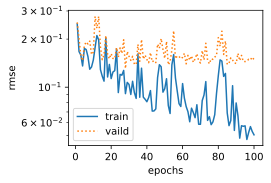

fold 0, train rmse 0.050383,vaild rmse 0.148790
fold 1, train rmse 0.069627,vaild rmse 0.175719
fold 2, train rmse 0.066723,vaild rmse 0.161774
fold 3, train rmse 0.069104,vaild rmse 0.123603
fold 4, train rmse 0.056637,vaild rmse 0.164511
5-fold vaildation:avg train rmse 0.062495,avg vaild rmse 0.154879


In [64]:
# 5 模型选择
k,num_epochs,lr,weight_decay,batch_size=5,100,5,0,64
train_l,vaild_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print('%d-fold vaildation:avg train rmse %f,avg vaild rmse %f'%(k,train_l,vaild_l))

In [ ]:
# 6 生成提交结果
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
  net=get_net()
  train_ls,_=train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
  d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse')
  print('train rmse %f'%train_ls[-1])
  preds=net(test_features).asnumpy()
  test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
  submission=pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
  submission.to_csv('submission.csv',index=False)

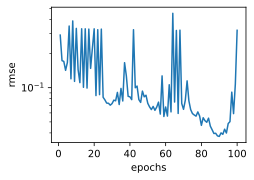

train rmse 0.319992


In [69]:
train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)